## Elephant Intrusion Detection and Repulsive System - GUI Application

#### Problem Statement :
Coffee and Tea estates in places like the Nilgiris are often bordering forests where one can find few wild animals,
but one can surely find lots of elephants. These elephants are not interested in Coffee and Tea but most of the estates are
sometimes on their path to reach a banana plantation, or the estates themselves have banana trees etc. Now once these
elephants enter the estates then they are very tough to get rid of without seeing them cause destruction and eventually
leave once they are satisfied. <br/><br/>
Currently barbed wire fences or electrically activated fences are what are the solutions employed to prevent them from
entering but they don’t seem to keep these huge mammals away.
What such estate owners often look for is the ability to get to know about arrival of elephants early enough so that they can
keep them away or do whatever is needed at their end to be better prepared to handle these situations.
So, elephant intrusion detection is of huge value to such estate owners who incur massive losses due to such intrusions.

#### Domain :
Agri Tech

#### Objective :
In this notebook, we will load the previously saved YoloV3 model <b>elephant_predictor_yolov3_model.h5</b> and use it to predict images along with bounding boxes. <br/>
We will also develop <b>Proximity algorithmn</b> to determine the proximity of elephants in a given image and also develop logic to determine the presence of baby elephants in an image.<br/> 
This model is integrated into GUI application created using tkinter

#### 1.0 Import the libraries

In [1]:
import numpy as np
import os
from time import sleep
from numpy import expand_dims
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import tkinter as tk
from PIL import Image, ImageTk

#### 2.0 Define Custom functions

In [2]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
        
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

##### 2.1 Decode Output function

Next we will define a function that will take each one of the NumPy arrays, one at a time, and decode the candidate bounding boxes and class predictions. <br/>Further, any bounding boxes that don’t confidently describe an object (e.g. all class probabilities are below a threshold) are ignored. <br/>

In [3]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    decoded_boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w                     # center position, unit: image width
            y = (row + y) / grid_h                     # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box_d = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            
            decoded_boxes.append(box_d)

    return decoded_boxes

##### 2.2 Translate Bounding Box Function

Define a function to perform the translation of bounding box coordinates which can be stretched back into the shape of original image, taking the list of bounding boxes, the original shape of our loaded photograph, and the shape of the input to the network as arguments. The coordinates of the bounding boxes are updated directly. <br/>

In [4]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [5]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

In [6]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

##### 2.3 Non Maximal Suppression function

The model will predict a lot of candidate bounding boxes, and most of the boxes will be referring to the same objects. The list of bounding boxes can be filtered and those boxes that overlap and refer to the same object can be merged. We can define the amount of overlap as a configuration parameter, and in our case we have chosen 50% or 0.5. This filtering of bounding box regions is generally referred to as <b>non-maximal suppression</b> and is a required post-processing step.

We will define a function that takes the list of bounding boxes and a threshold parameter. Rather than purging the overlapping boxes, their predicted probability for their overlapping class is cleared. This allows the boxes to remain and be used if they also detect another object type.

In [7]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

##### 2.4 Image Pre-processing function

Next we define a function that will takes the image file-name along with the target size as inputs and returns the scaled pixel data ready to provide as input to the detection model, as well as the original width and height of the image. <br/><br/>

In [8]:
# load and prepare an image

def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size

    # load the image with the required size
    image = load_img(filename, target_size=shape)

    # convert to numpy array
    image = img_to_array(image)

    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

##### 2.5 Draw Bounding Boxes functions

The model will predict a large number of boxes, but only very few of interest. We can retrieve just those boxes that strongly predict the presence of an object. This can be achieved by enumerating over all boxes and checking the class prediction values. We can then look up the corresponding class label for the box and add it to the list. Each box must be considered for each class label, just in case the same box strongly predicts more than one object.

We will define a function that does this and takes the list of boxes, known labels, and our classification threshold as arguments and returns parallel lists of boxes, labels, and scores. <br/>

In [9]:
# get all of the results above a threshold

def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()

    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
                
    return v_boxes, v_labels, v_scores

In [10]:
# draw all results

def draw_boxes(filename, v_boxes, v_labels, v_scores):
    coordinates = list()
    
    # load the image
    disp_filename = filename.split('/')[-1]
    data = pyplot.imread(filename)
    
    # plot the image
    pyplot.imshow(data)
    
    # get the context for drawing boxes
    ax = pyplot.gca()
    ax.set_axis_off()
    
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        
        #Skip objects other than ones of interest
        if v_labels[i] not in ['elephant','person']:
            continue
            
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        coordinates.append([x1, y1, x2, y2, v_labels[i], v_scores[i]])
        
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='Red')
        
        # draw the box
        ax.add_patch(rect)
        
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='Green')
    
    # show the plot
    print (f'Saving predicted image as : CV_{disp_filename}')
    pyplot.savefig(f'CV_{disp_filename}',  bbox_inches='tight')
    pyplot.show()
    return coordinates
   

#### 3.1 Proximity Algorithm 

Functin to determine the proximity of the elephants based on the height of the bounding box.

In [11]:
def find_proximity(bbox_cord, image_height):
    prox_alert = 'NA'
    height = []
    for i in range(len(bbox_cord)): 
        if bbox_cord[i][4] not in ['elephant']:
            continue
        height.append(bbox_cord[i][3] - bbox_cord[i][1])
    
    if (len(height)>0):
        height.sort()
        if  height[-1] >= (0.6 * image_height):
            prox_alert = 'NEAR'
        elif (height[-1] >= (0.2 * image_height) and height[-1] < (0.6 * image_height)):
            prox_alert = 'MEDIUM'
        else:
            prox_alert = 'FAR'
            
    return prox_alert

#### 3.2 Baby elephant determination

Function to determine the presence of Baby elephants 

In [12]:
def find_Baby_Elephant(bbox_cord, image_height):
    baby_found = 'N'
    height = []
    bbox_cord_shortest = []
    bbox_cord_tallest = []
    
    for i in range(len(bbox_cord)): 
        if bbox_cord[i][4] not in ['elephant']:
            continue
        height.append(bbox_cord[i][3] - bbox_cord[i][1])
        
    if (len(height)== 0):
        #No Elephants found 
        return 'NA'
    
    if (len(height)== 1):
        # ONLY ONE ELEPHANT CANT BE BABY ELEPHANT
        return baby_found
    
    height.sort()
    
    for i in range(len(bbox_cord)): 
            if bbox_cord[i][4] not in ['elephant']:
                continue
            if (height[-1] == (bbox_cord[i][3] - bbox_cord[i][1])):
                bbox_cord_tallest = bbox_cord[i]
            if (height[0] == (bbox_cord[i][3] - bbox_cord[i][1])):
                bbox_cord_shortest = bbox_cord[i]  
    
    if (height[-1] < 0.4 * image_height):
        # ELEPHANTS TOO FAR TO CALL AS ADULT OR BABY
        return baby_found
    
    if ( height[0] < (0.5 * height[-1])):
        # POSSIBLE BABY ELEPHANT
        if (bbox_cord_tallest[0] > bbox_cord_shortest[2]):             # baby on left 
            # BABY ELEPHANT ON LEFT
            dist = bbox_cord_tallest[0] - bbox_cord_shortest[2]
            
            if (dist > 20 and (bbox_cord_shortest[3] < 0.4 * bbox_cord_tallest[3]) ):
                # ELEPHANT ON LEFT NOT BABY
                pass
            else: 
                if (bbox_cord_shortest[1] > bbox_cord_tallest[1]):      # shortest ymin greater than tallest ymin
                    # FOUND BABY ELEPHANT ON LEFT
                    baby_found = 'Y'
        else:
            if (bbox_cord_tallest[2] < bbox_cord_shortest[0]):          # baby on right 
                # BABY ELEPHANT ON RIGHT
                dist = bbox_cord_shortest[0] - bbox_cord_tallest[2]
                if (dist > 20 and (bbox_cord_shortest[3] < bbox_cord_tallest[3])):
                    pass
                else: 
                    if (bbox_cord_shortest[1] > bbox_cord_tallest[1]):  # shortest ymin greater than tallest ymin
                        # FOUND BABY ELEPHANT ON RIGHT
                        baby_found = 'Y'
            else:   
                if ((bbox_cord_shortest[1] > bbox_cord_tallest[1]) and (bbox_cord_shortest[3] > 0.8 * bbox_cord_tallest[3])):# shortest ymin greater than tallest ymin
                        # FOUND BABY ELEPHANT'
                        baby_found = 'Y'
    #else:
    #    print('NO BABY ELEPHANT FOUND') #To be commented
    
    return baby_found

#### 4.0 Predictor function

Function which will take the input image and run the model to get the prediction and run the post processing steps to draw and plot the bounding boxes of all classes above the confidence threshlold

In [13]:
def predict_image(predict_image):
    # define our new photo
    photo_filename = f'{relevant_path}/{predict_image}'
    input_w, input_h = 416, 416

    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

    # make prediction
    yhat = model.predict(image)

    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])

    # define the anchors
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

    # define the probability threshold for detected objects
    class_threshold = 0.12
    boxes = []
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)


    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # suppress non-maximal boxes
    do_nms(boxes, 0.5)


    # get the details of the detected objects
    v_boxes, v_labels, v_scores = list(), list(), list()
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    # summarize what we found
    elephant_cntr = 0 
    humans_present= 'N'
    for i in range(len(v_boxes)):
        #print(v_labels[i], v_scores[i])
        if v_labels[i] == 'elephant':
            elephant_cntr += 1
        
        if v_labels[i] == 'person':
            humans_present = 'Y'
    
    # draw what we found
    cord = draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
    proximity = find_proximity(cord, image_h)
    baby_present = find_Baby_Elephant(cord, image_h)
    
    print ('Summary : \n')
    print ('Num of elephants : ', elephant_cntr)
    print ('Humans Present   : ', humans_present)
    print ('Proximity        : ', proximity)
    print ('Baby Elephant    : ', baby_present)
    #print (cord)
    alarm = 'GREEN'
    if elephant_cntr == 0:
        alarm = 'GREEN'
    elif humans_present == 'Y':
        alarm = 'YELLOW'
    elif proximity == 'FAR' and elephant_cntr < 3:
        alarm = 'YELLOW'
    elif proximity == 'FAR' and elephant_cntr >= 3:
        alarm = 'ORANGE'
    elif proximity == 'MEDIUM' and elephant_cntr < 5:
        alarm = 'ORANGE'
    elif proximity == 'MEDIUM' and elephant_cntr >=3:
        alarm = 'RED'
    elif proximity == 'NEAR':
        alarm = 'RED'
    
    print ('Alarm Level     : ', alarm)
    print ('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=\n')
    return elephant_cntr, humans_present, proximity, baby_present, alarm

#### 5.0 GUI Application Class

Class to create GUI window to load and show the preicted output image

In [14]:
#from tkmacosx import Button

class App:
    #def __init__(self, master=tk.Tk()):
    def __init__(self, master=tk.Toplevel()):
        self.master = master
        self.fig_size = [600, 600]
        self.frame = tk.Frame(master)
        self.canvas = tk.Canvas(self.frame, width=1280, height=800)
        self.canvas.pack()

        self.idx = 0 
        self.elephants = 0
        self.humans = 'N'
        self.proximity = 'NA'
        self.babyele = 'N'
        self.alarmclr = 'GREEN'
        self.fig_image = ImageTk.PhotoImage(Image.open('images/Cover-Image.jpeg').resize(self.fig_size, Image.BILINEAR))
        self.image_label = tk.Label(self.canvas, image=self.fig_image)
        self.image_label.pack()
        
        self.button_alarm = tk.Button(self.frame, text="Stay Tuned - system loading")
        self.button_alarm.pack(anchor='center')
        
        self.Label_ecnt = tk.Label(self.frame, text= "ELEPHANT INTRUSION")
        self.Label_ecnt.pack(anchor='center')

        self.Label_human = tk.Label(self.frame, text="    DETECTION ")
        self.Label_human.pack(anchor='center')
                
        self.Label_baby  = tk.Label(self.frame, text="     SYSTEM   ")
        self.Label_baby.pack(anchor='center')
        
        self.Label_prox  = tk.Label(self.frame, text=" AND REPULSIVE ")
        self.Label_prox.pack(anchor='center')

        self.init_load_image('images/Cover-Image.jpeg')
        self.canvas.after(2500, self.update)
        
        self.frame.bind("q", self.close)
        self.frame.bind("<Escape>", self.close)
        self.frame.pack()
        self.frame.focus_set()

        self.is_active = True

        
    def load_image(self, filename):
        try:
            #self.fig_image = ImageTk.PhotoImage(Image.open(filename).resize(self.fig_size, Image.BILINEAR))
            #sleep(3)
            try :
                self.elephants, self.humans, self.proximity, self.babyele, self.alarmclr = predict_image(filename)
                self.fig_image = ImageTk.PhotoImage(Image.open(f'CV_{filename}').resize(self.fig_size, Image.BILINEAR))
                self.Label_ecnt.configure(text= "\nElephants    : " + str(self.elephants), font=("Arial", 14))
                self.Label_human.configure(text="Humans       : " + str(self.humans), font=("Arial", 14))
                self.Label_prox.configure(text= "Proximity    : " + str(self.proximity), font=("Arial", 14))
                self.Label_baby.configure(text= "Baby Elephant: " + str(self.babyele), font=("Arial", 14))
                self.button_alarm.configure(text='                                      \n \n             ALERT LEVEL            \n \n \n', font=("Arial", 16),bg=self.alarmclr)
                
            except Exception as e:
                pass
            
            self.idx +=1
        except : 
            self.master.quit()
            self.is_active = False

    def update(self, *args):
        self.load_image(file_names[self.idx])
        self.image_label.config(image=self.fig_image)
        self.canvas.after(10, self.update)
        
    def close(self, *args):
        print('GUI closed...')
        self.master.quit()
        self.is_active = False

    def is_closed(self):
        return not self.is_active

    def mainloop(self):
        self.master.mainloop()
        print('mainloop closed...')
        
    def init_load_image(self, filename):
        try:
            try :
                self.fig_image = ImageTk.PhotoImage(Image.open(filename).resize((600, 600), Image.BILINEAR))
                self.Label_ecnt.configure(text= "  ")
                self.Label_human.configure(text="    ELEPHANT INTRUSION DETECTION ", font=("Arial", 25) )
                self.Label_baby.configure(text= " & ", font=("Arial", 25) )
                self.Label_prox.configure(text= "     REPULSIVE SYSTEM    \n\n", font=("Arial", 25) )
                
                self.button_alarm.configure(text="......", borderless=1, bg="#eeeeee")
                self.image_label.config(image=self.fig_image)
            except Exception as e:
                pass
        except : 
            self.master.quit()
            self.is_active = False

            

Loading Model .........
Model Loaded successfully !!!!! 

Generating list of images in the directory ......
Found [37] images in the directory......
Launching GUI interface ......
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_00.jpg


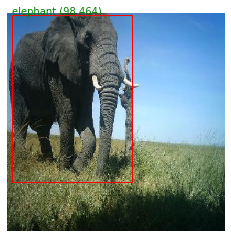

Summary : 

Num of elephants :  1
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_02.jpg


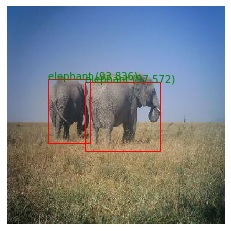

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_03.jpg


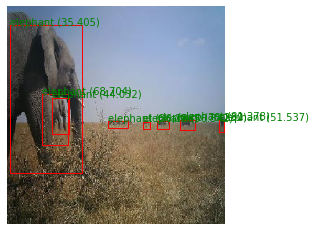

Summary : 

Num of elephants :  8
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_04.jpg


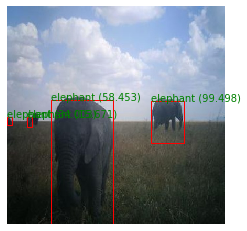

Summary : 

Num of elephants :  4
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  Y
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_05.jpg


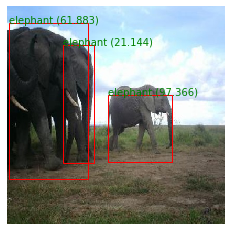

Summary : 

Num of elephants :  3
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_06.jpg


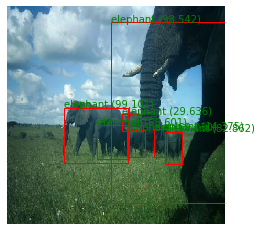

Summary : 

Num of elephants :  7
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_08.jpg


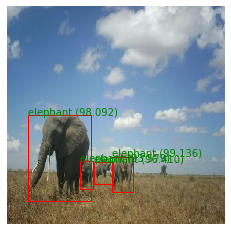

Summary : 

Num of elephants :  4
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_09.jpg


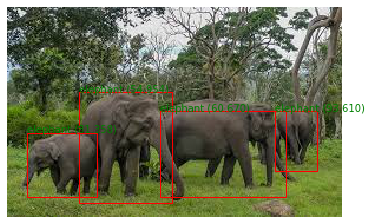

Summary : 

Num of elephants :  4
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_10.jpg


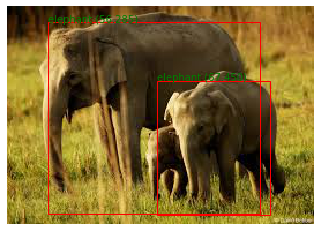

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_11.jpg


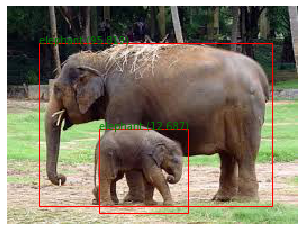

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_12.jpg


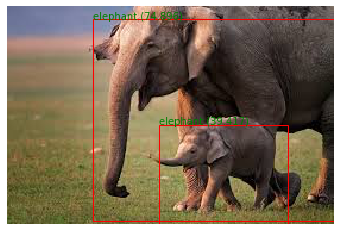

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_13.jpg


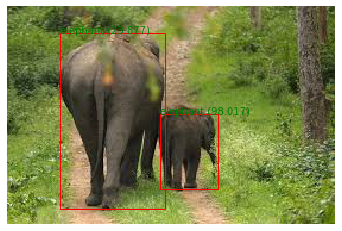

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  Y
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_14.jpg


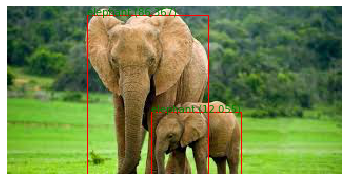

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  Y
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_15.jpg


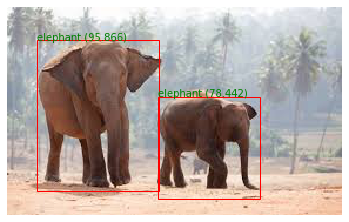

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_16.jpg


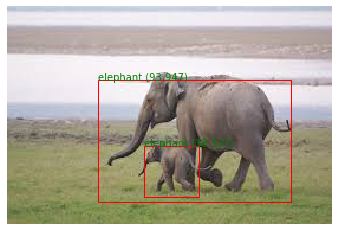

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  Y
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_18.jpg


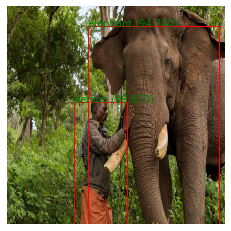

Summary : 

Num of elephants :  1
Humans Present   :  Y
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_19.jpg


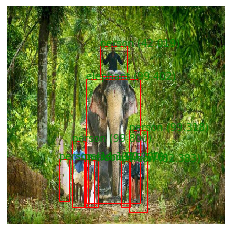

Summary : 

Num of elephants :  1
Humans Present   :  Y
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_20.jpg


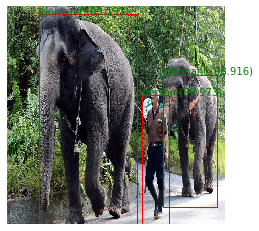

Summary : 

Num of elephants :  2
Humans Present   :  Y
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_22.jpg


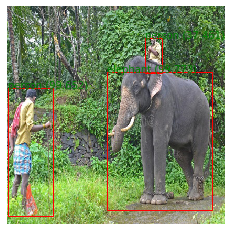

Summary : 

Num of elephants :  1
Humans Present   :  Y
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_23.jpg


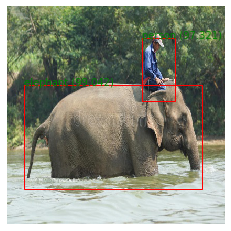

Summary : 

Num of elephants :  1
Humans Present   :  Y
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_25.jpg


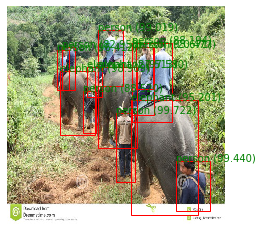

Summary : 

Num of elephants :  4
Humans Present   :  Y
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_27.jpeg


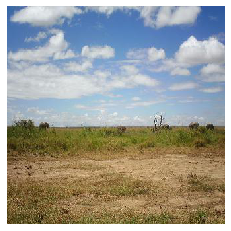

Summary : 

Num of elephants :  0
Humans Present   :  N
Proximity        :  NA
Baby Elephant    :  NA
Alarm Level     :  GREEN
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_28.jpeg


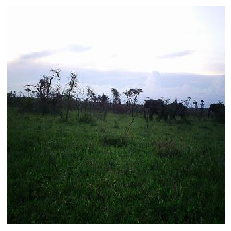

Summary : 

Num of elephants :  0
Humans Present   :  N
Proximity        :  NA
Baby Elephant    :  NA
Alarm Level     :  GREEN
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_29.jpeg


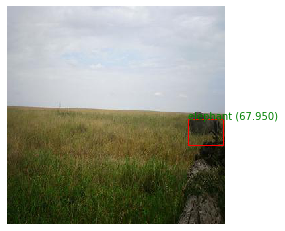

Summary : 

Num of elephants :  1
Humans Present   :  N
Proximity        :  FAR
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_30.jpeg


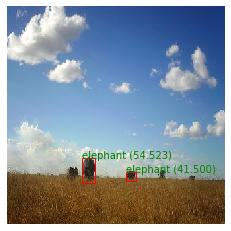

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  FAR
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_31.jpeg


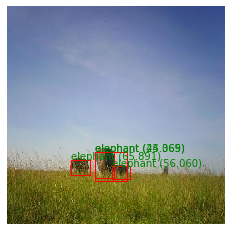

Summary : 

Num of elephants :  4
Humans Present   :  N
Proximity        :  FAR
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_32.jpeg


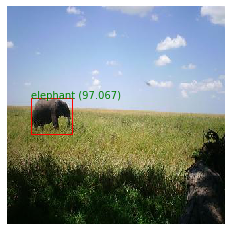

Summary : 

Num of elephants :  1
Humans Present   :  N
Proximity        :  FAR
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_33.jpeg


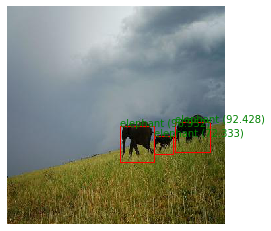

Summary : 

Num of elephants :  3
Humans Present   :  N
Proximity        :  FAR
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_34.jpeg


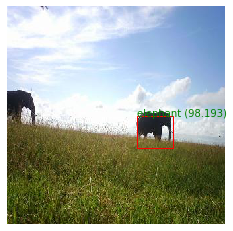

Summary : 

Num of elephants :  1
Humans Present   :  N
Proximity        :  FAR
Baby Elephant    :  N
Alarm Level     :  YELLOW
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_35.jpeg


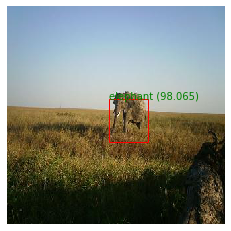

Summary : 

Num of elephants :  1
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_36.jpeg


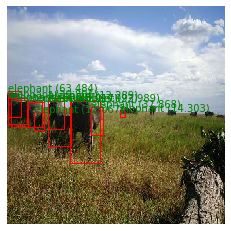

Summary : 

Num of elephants :  10
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_37.jpeg


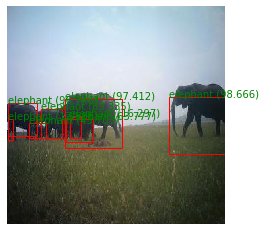

Summary : 

Num of elephants :  8
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_38.jpeg


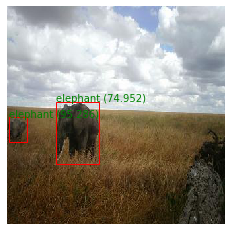

Summary : 

Num of elephants :  2
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_39.jpeg


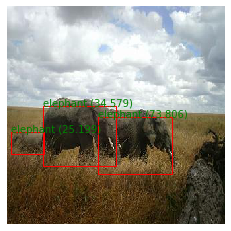

Summary : 

Num of elephants :  3
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_40.jpeg


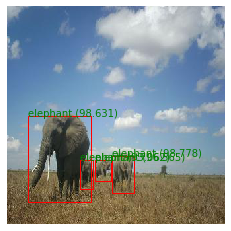

Summary : 

Num of elephants :  4
Humans Present   :  N
Proximity        :  MEDIUM
Baby Elephant    :  N
Alarm Level     :  ORANGE
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_41.jpeg


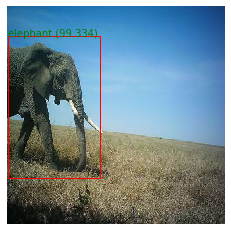

Summary : 

Num of elephants :  1
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Saving predicted image as : CV_img_43.jpg


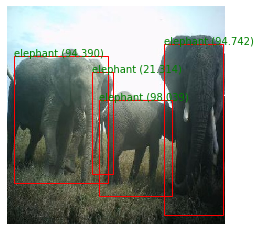

Summary : 

Num of elephants :  4
Humans Present   :  N
Proximity        :  NEAR
Baby Elephant    :  N
Alarm Level     :  RED
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\hp\anaconda3\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-14-31e5f9912584>", line 70, in update
    self.load_image(file_names[self.idx])
IndexError: list index out of range


mainloop closed...


In [15]:
# load yolov3 model
print ('Loading Model .........')
model = load_model('elephant_predictor_yolov3_model.h5')
print ('Model Loaded successfully !!!!! \n')

# define the expected input shape for the model
input_w, input_h = 416, 416

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


print ('Generating list of images in the directory ......')
relevant_path = r'images/Predict'
included_extensions = ['jpg','jpeg']

file_names = [fn for fn in os.listdir(relevant_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

file_names.sort()

print (f'Found [{str(len(file_names))}] images in the directory......')

print ('Launching GUI interface ......')
app = App()
app.mainloop()


#### Summary and Conclusion

We were successfully able to create a GUI based application to detect and localize elephants, baby elephants and humans.<br/><br/>
We also developed a logic to determine the proximity of the elephant(s) and presence of baby elephant(s) in the images. <br/><br/>
Next we developed an alarm system with following 4 Levels in increasing order of severity:
1. GREEN - No presence of elephants in the image
2. YELLOW - If the elephant is far or presence of humans in the image
3. ORANGE - If more than 3 elephants are seen or if the Proximity is medium 
4. RED - If a herd of elephants is detected or if the Proximity is near<br/><br/>

#### Further Scope

1. Integrate the system to CCTV camera video output
2. Integrate Sound alarm systems based on different severity levels to wade off the elephants 